# Image Offsets - Centroid precision analysis

Tables generated by the previous notebook (Offsets_2) are used to build some statistics associated with centroiding. 

This is a crucial step in drizzle implementation, since we must assure that the pixel offsets created by this process have sufficient precision to even justify drizzling in the first place. Remember that we are using Bayer RGB raw arrays as a source for centroiding, so color effects may be of importance here.

This script also provides the means to reject stars with large residuals in centroid position.

In [1]:
import os, glob
import random
import math

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import rawpy

from datapath import DATA

## Read tables created by previous notebook

In [2]:
datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')
file_list = glob.glob(datadir + '*.offsets_table.fits')
file_list.sort()
table_list = [Table.read(x) for x in file_list]

## Read image to get array size

In [3]:
# last table in sequence
last = file_list[-1]

# prototype image
image_name = last.split('/')[-1]
image_name = image_name.replace('.offsets_table.fits', '.ARW')
image_name = os.path.join(datadir, image_name)
raw = rawpy.imread(image_name)
imarray = raw.raw_image_visible.astype(float)

ny = imarray.shape[0]
nx = imarray.shape[1]

print(nx, ny)

4256 2848


## Functions

These functions plot centroids (Y against X) as a function of time (or image number in sequence) to gauge the precision to which we can recover the centroid from the highly under-sampled data.

In [4]:
# gets row index of star nearest to the supplied coordinates. 
def get_nearest_index(x, y, table):
    min_dist = math.sqrt(float(nx)**2 + float(ny)**2)
    row_index_min_dist = 0

    for row_index in range(len(table)):
        xcent = table['xcentroid'][row_index]
        ycent = table['ycentroid'][row_index]
        
        dist = math.sqrt((x - xcent)**2 + (y - ycent)**2)
        
        if (dist < min_dist):
            min_dist = dist
            row_index_min_dist = row_index

    return row_index_min_dist

In [5]:
# fits a straight line thru centroids and compute residuals
def fit_line(table_list, input_row_index):
    row_index = input_row_index

    # collect all centroid measurements of the given star
    x_data = []
    y_data = []
    for table_object in reversed(table_list):
    
        x_data.append(table_object['xcentroid'][row_index])
        y_data.append(table_object['ycentroid'][row_index])

        # update row index to point to previous' table row that 
        # corresponds to this star.
        row_index = table_object['prev_row'][row_index]

    # fit straight line and compute residuals
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

    pred_values = slope * x_data + intercept
    residuals = y_data - pred_values
    stdev = math.sqrt(np.sum(residuals**2) / len(residuals))
    
    return stdev, slope, intercept, x_data, y_data, residuals

In [6]:
def plot_residuals(x, y, table_list, nearest=False, large_resid=None):

    # last table in sequence 
    table_last = table_list[-1]

    # find in last table, the row corresponding to the input star, 
    # based on centroid column.
    tol = 2.0 # tolerance

    # we assume first, that the x,y coordinates are exact, that is,
    # they match within a tolerance, an existing table row.
    found = False
    for row_index in range(len(table_last)):
        xcent = table_last['xcentroid'][row_index]
        ycent = table_last['ycentroid'][row_index]

        if (abs(x - xcent) < tol and abs( y - ycent) < tol):
            found = True
            break

    # if no row with matching x,y centroids can be found, we can either
    # pick any row at random, or look for the nearest centroid to the 
    # given x,y position.
    if not found:
        if nearest:
            print("Coordinates: ", x, y, ". Picking nearest star.")
            row_index = get_nearest_index(x, y, table_last)
        else:
            print("Cannot find star near ", x, y, ". Picking at random.")
            row_index = random.randrange(len(table_last))

        x = table_last['xcentroid'][row_index]
        y = table_last['ycentroid'][row_index]

    # fit line
    stdev, slope, intercept, x_data, y_data, residuals = fit_line(table_list, row_index)

    # plot
    if large_resid is None or (large_resid is not None and stdev > large_resid):
        fig, (ax1, ax2) = plt.subplots(1, 2)
    #     fig.set_size_inches(8.5, 3.5) # interactive notebook
        fig.set_size_inches(12.5, 5.5)

        for xp,yp,r in zip(x_data, y_data, residuals):
            ax1.plot(xp, yp, 'ro')
            ax2.plot(xp, r, 'ro')

        title = 'x = {:.2f} y = {:.2f}'.format(x, y)
        sigma = '\u03C3 = {:.3f}'.format(stdev)

        ax1.grid()
        ax2.grid()
        ax1.set_title(title)
        ax2.set_title(sigma)

        fig.show()

These functions reject stars with large residuals, from all tables.

In [7]:
# keep only the NaN-free entries
def clean_nans(table):
    has_nan = np.zeros(len(table), dtype=bool)
    xoff = np.array(table['xcentroid'])
    has_nan |= np.isnan(xoff)
    return table[~has_nan]

In [8]:
def reject_stars(table_list, residual_threshold=0.6):

    # last table in sequence 
    table_last = table_list[-1]
    
    # scan rows in last table
    for last_table_row_index in range(len(table_last)):
        row_index = last_table_row_index

        # fit line for this star
        stdev, slope, intercept, _, _, _ = fit_line(table_list, row_index)

        if stdev > residual_threshold:
            print(last_table_row_index, stdev)
            
            # mark this star in all tables
            ri = last_table_row_index
            for table_object in reversed(table_list):
                table_object['xcentroid'][ri] = np.NaN
                ri = table_object['prev_row'][ri]

    # once all rows in all tables were marked, remove them.
    table_list_clean = []

    for table in table_list:
        table_list_clean.append(clean_nans(table))
        
    return table_list_clean

## Plot

The plots are in general consistent with precision of a fraction of one pixel. They seem to warrant the use of drizzle.

Coordinates:  500 500 . Picking nearest star.


/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_5938/4226465073.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Coordinates:  500 1000 . Picking nearest star.
Coordinates:  500 1500 . Picking nearest star.
Coordinates:  500 2000 . Picking nearest star.
Coordinates:  500 2500 . Picking nearest star.
Coordinates:  1000 500 . Picking nearest star.
Coordinates:  1000 1000 . Picking nearest star.
Coordinates:  1000 1500 . Picking nearest star.
Coordinates:  1000 2000 . Picking nearest star.
Coordinates:  1000 2500 . Picking nearest star.
Coordinates:  1500 500 . Picking nearest star.
Coordinates:  1500 1000 . Picking nearest star.
Coordinates:  1500 1500 . Picking nearest star.
Coordinates:  1500 2000 . Picking nearest star.
Coordinates:  1500 2500 . Picking nearest star.
Coordinates:  2000 500 . Picking nearest star.
Coordinates:  2000 1000 . Picking nearest star.
Coordinates:  2000 1500 . Picking nearest star.
Coordinates:  2000 2000 . Picking nearest star.
Coordinates:  2000 2500 . Picking nearest star.
Coordinates:  2500 500 . Picking nearest star.


/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_5938/4226465073.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2)


Coordinates:  2500 1000 . Picking nearest star.
Coordinates:  2500 1500 . Picking nearest star.
Coordinates:  2500 2000 . Picking nearest star.
Coordinates:  2500 2500 . Picking nearest star.
Coordinates:  3000 500 . Picking nearest star.
Coordinates:  3000 1000 . Picking nearest star.
Coordinates:  3000 1500 . Picking nearest star.
Coordinates:  3000 2000 . Picking nearest star.
Coordinates:  3000 2500 . Picking nearest star.
Coordinates:  3500 500 . Picking nearest star.
Coordinates:  3500 1000 . Picking nearest star.
Coordinates:  3500 1500 . Picking nearest star.
Coordinates:  3500 2000 . Picking nearest star.
Coordinates:  3500 2500 . Picking nearest star.
Coordinates:  4000 500 . Picking nearest star.
Coordinates:  4000 1000 . Picking nearest star.
Coordinates:  4000 1500 . Picking nearest star.
Coordinates:  4000 2000 . Picking nearest star.
Coordinates:  4000 2500 . Picking nearest star.


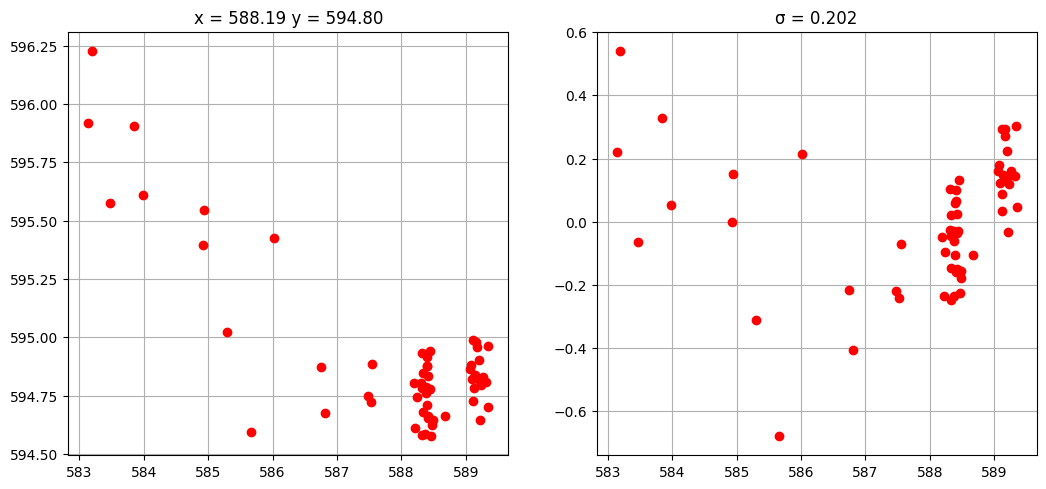

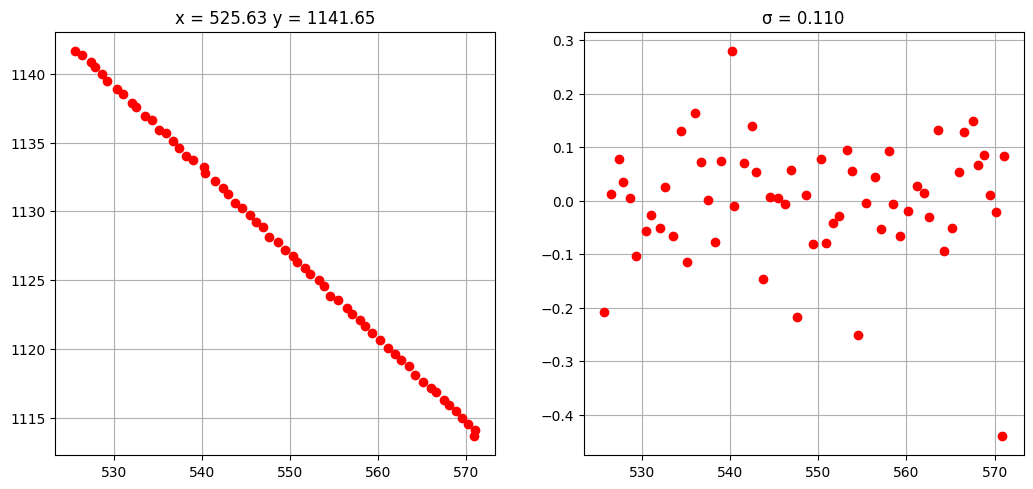

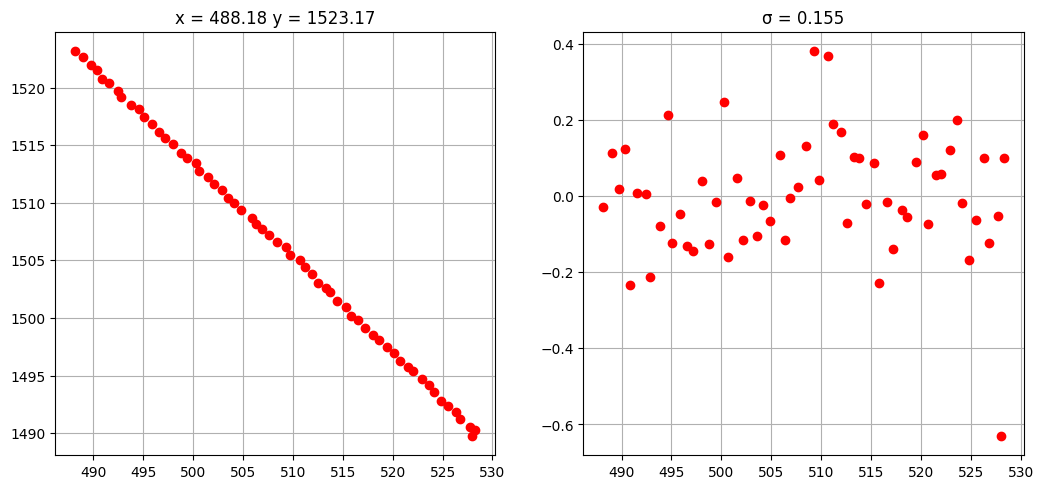

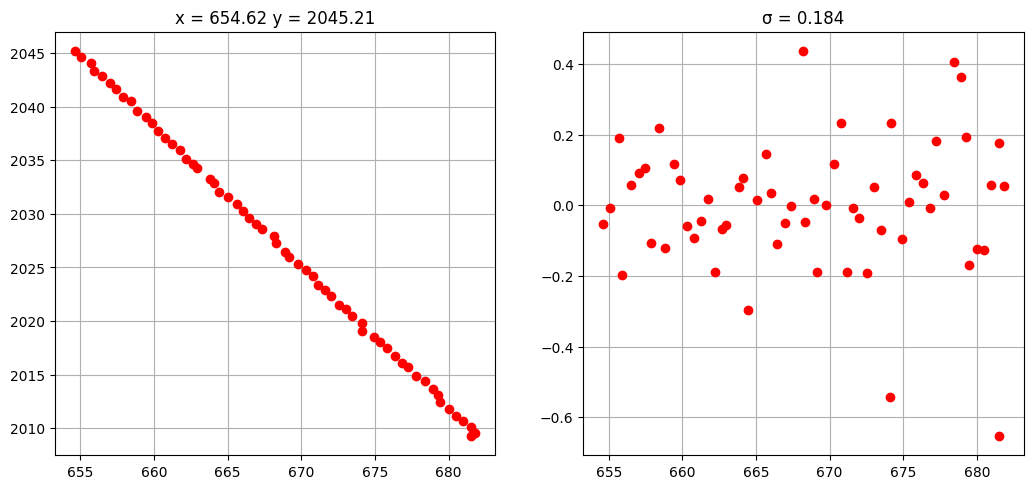

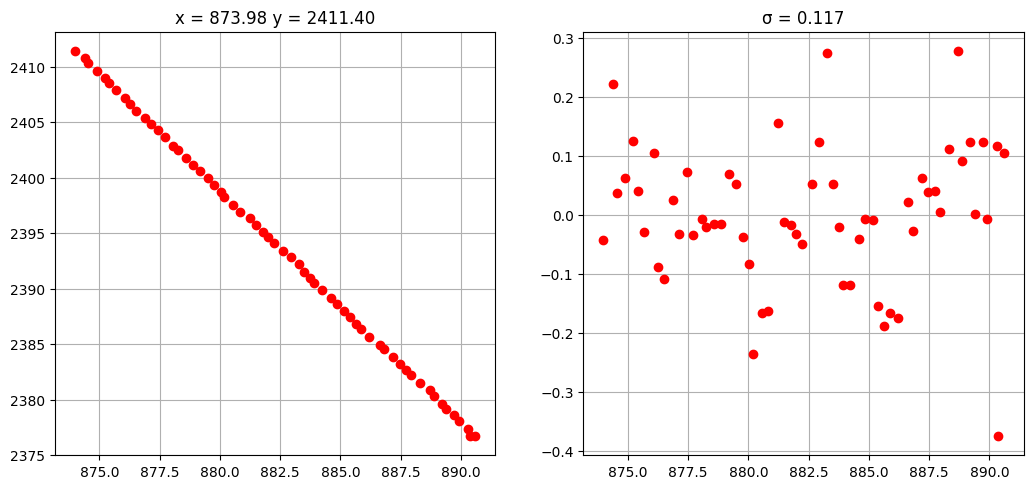

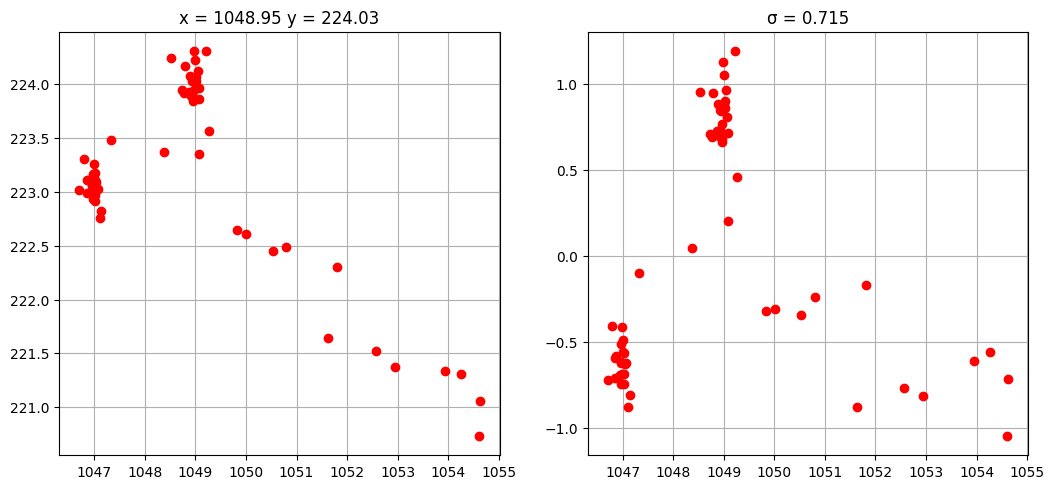

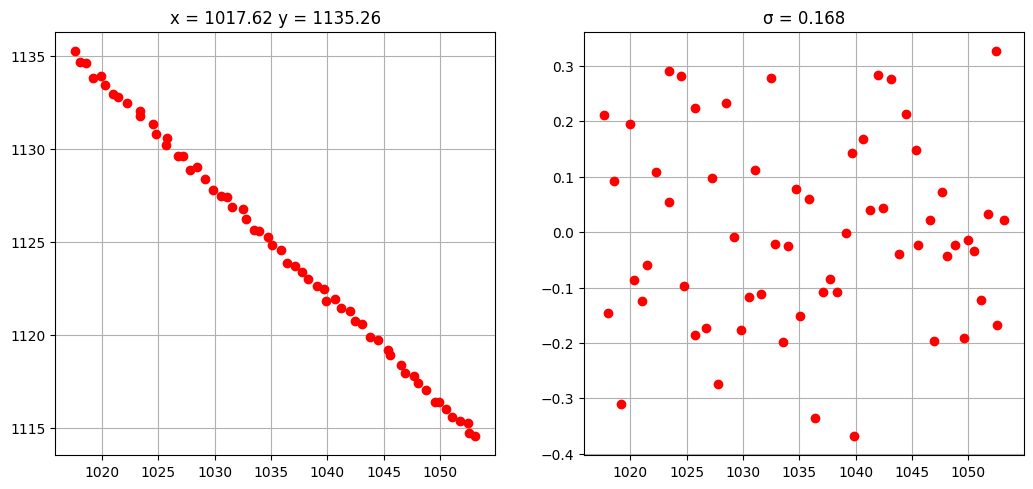

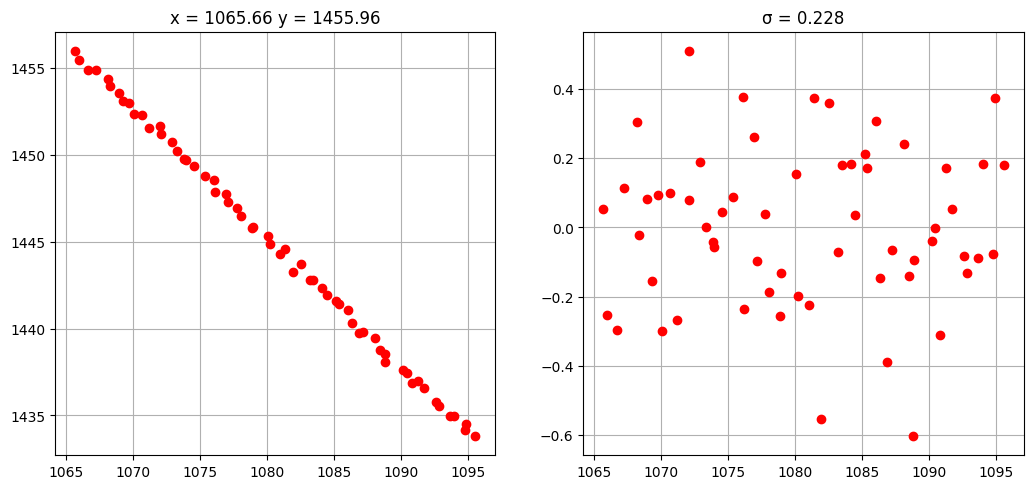

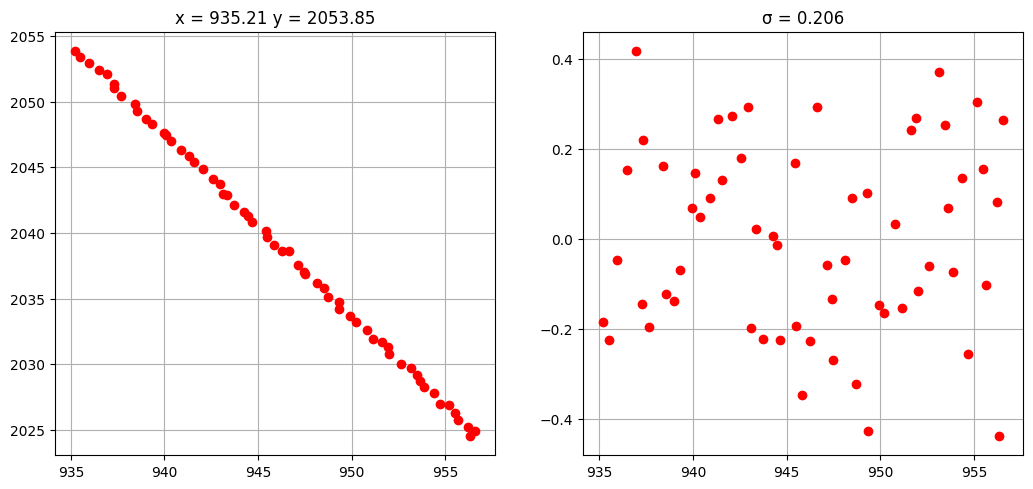

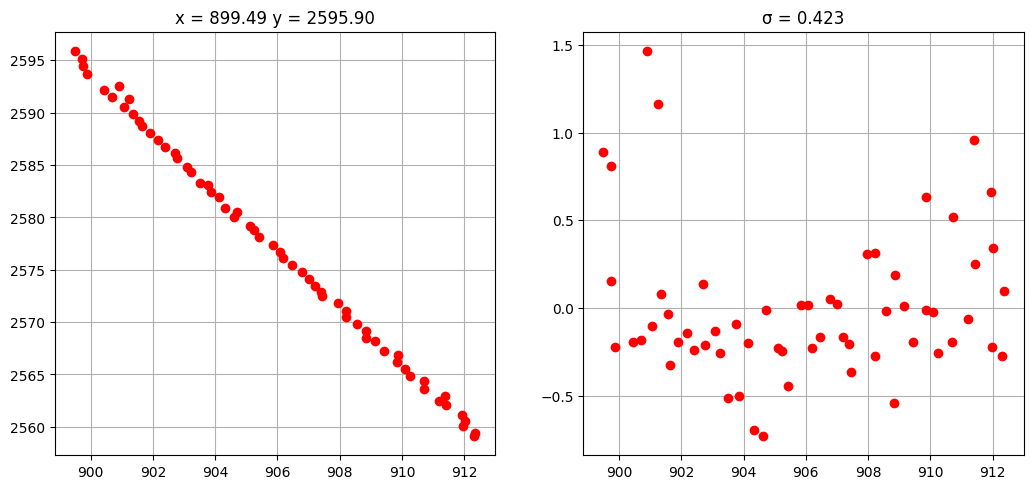

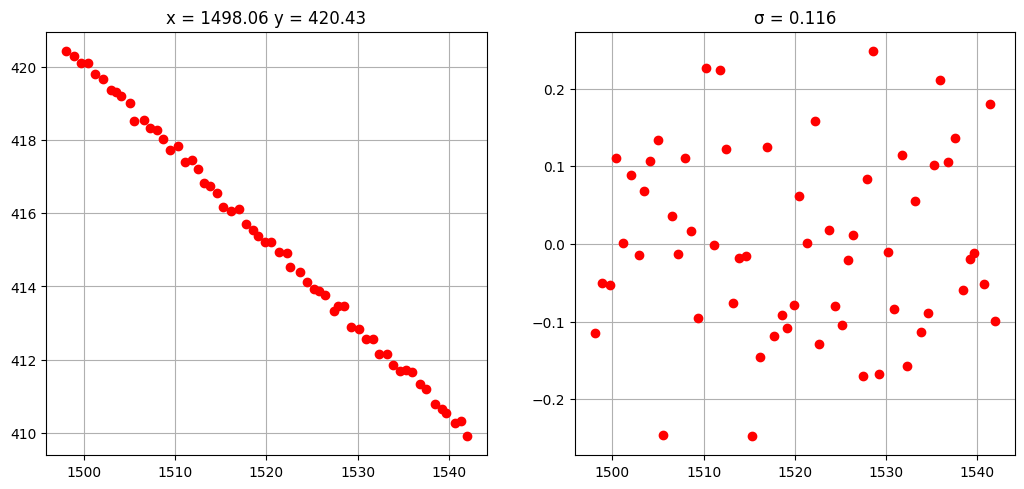

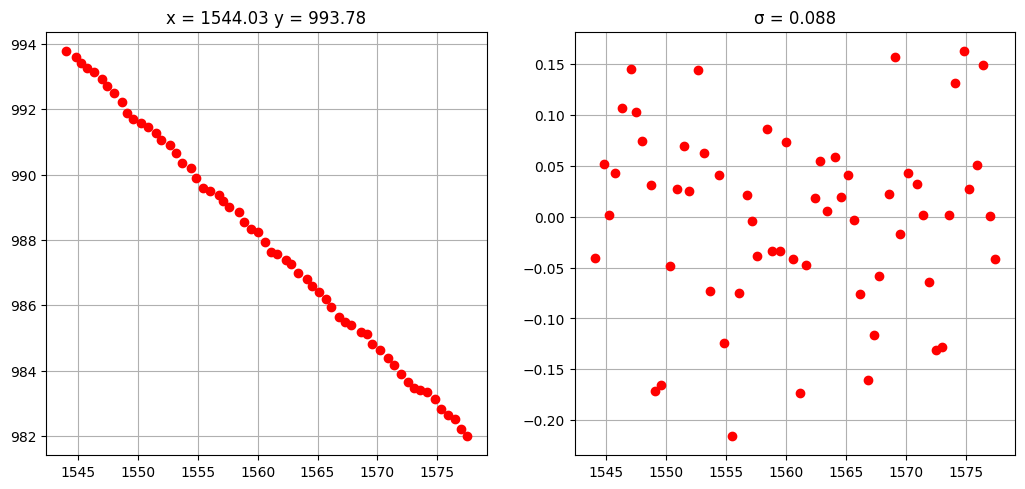

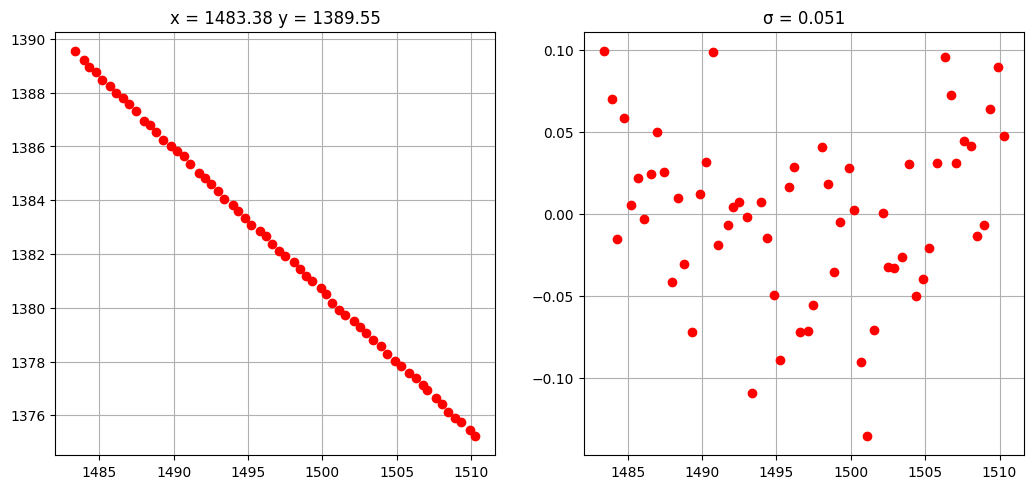

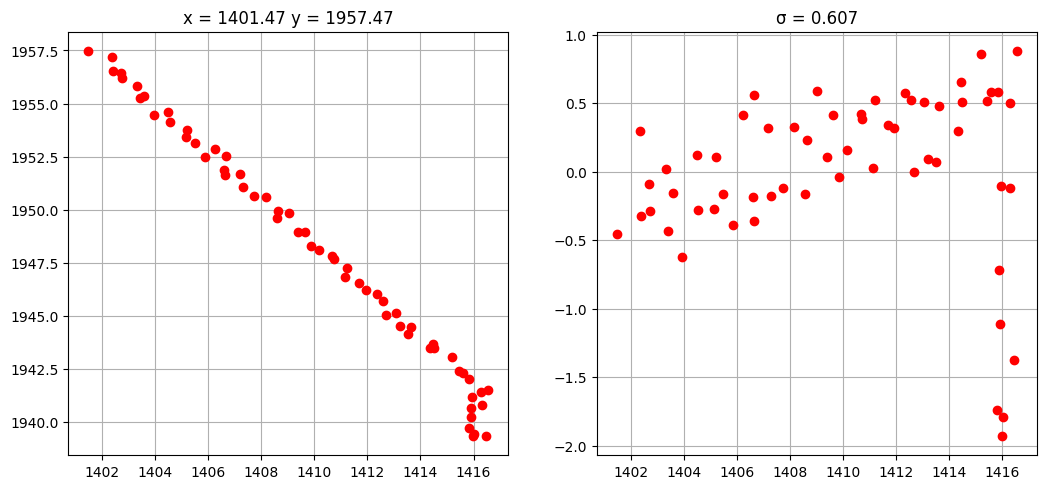

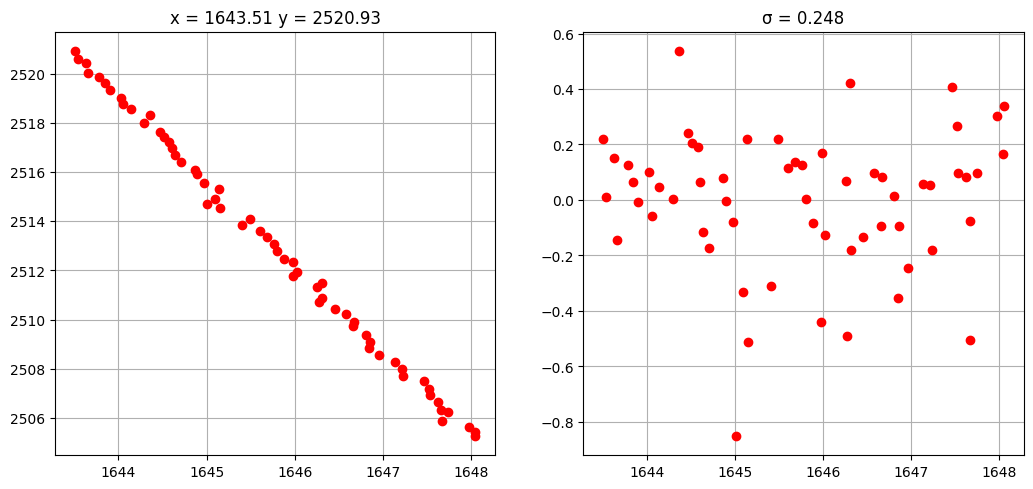

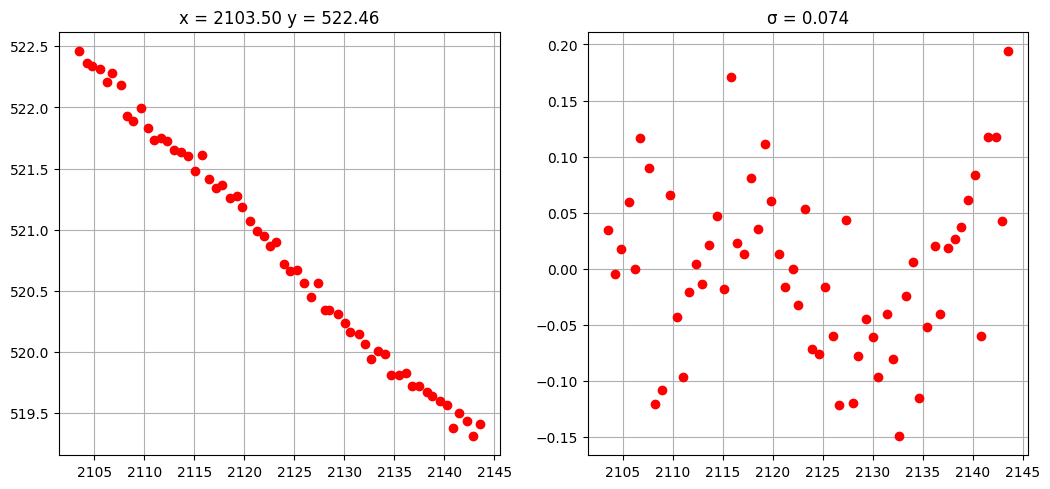

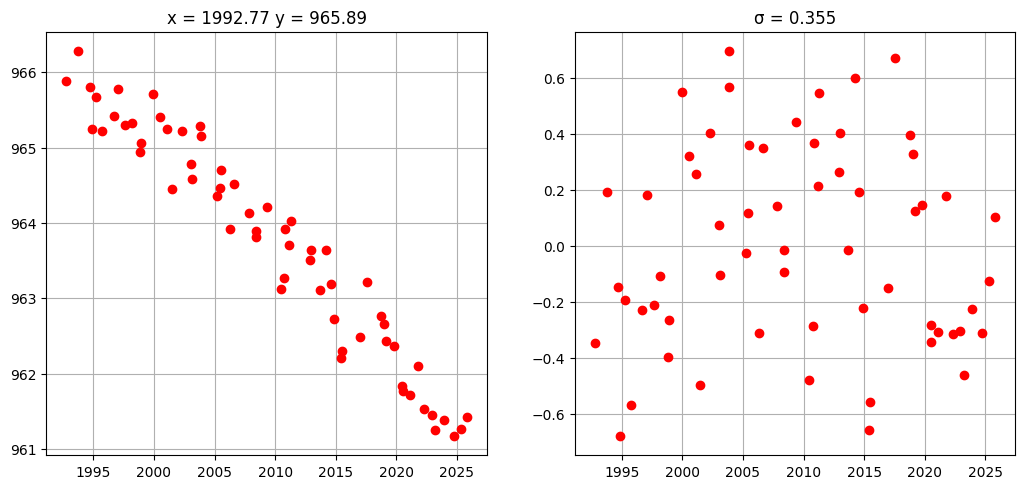

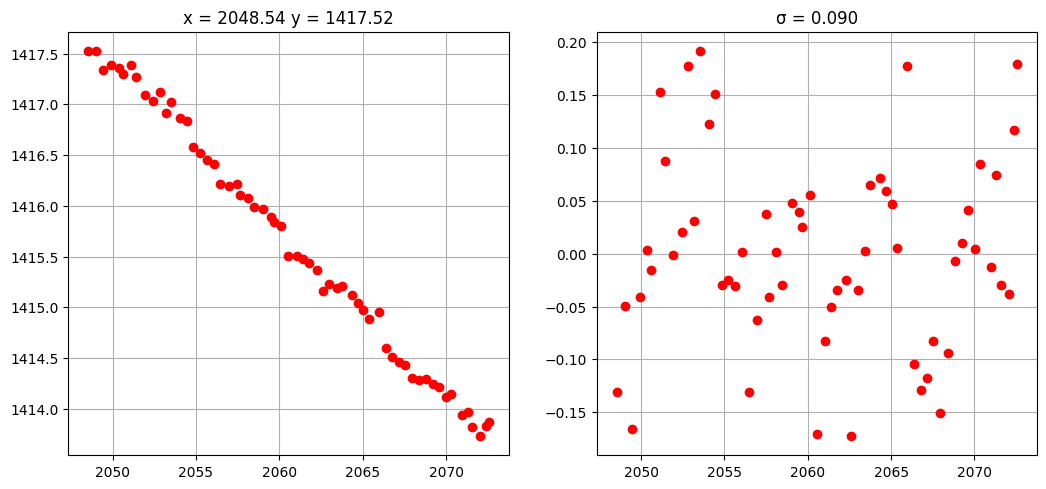

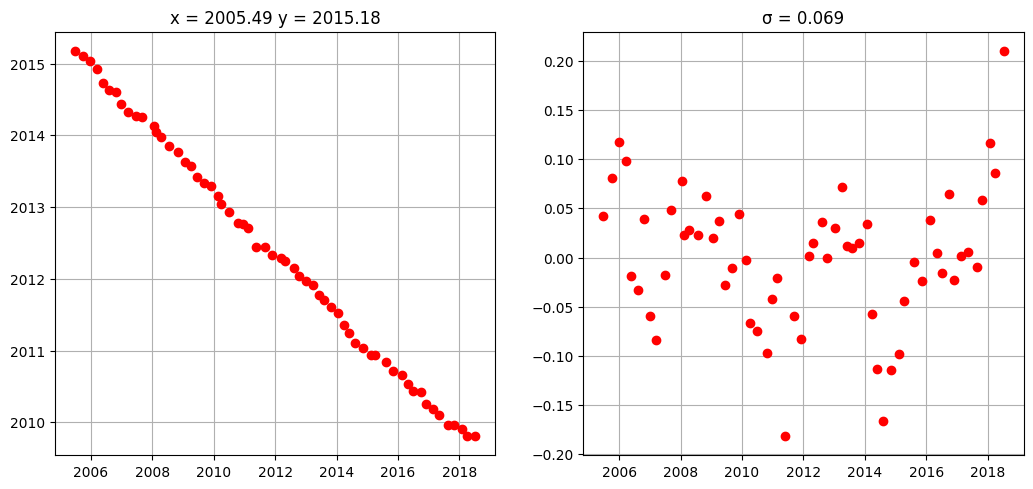

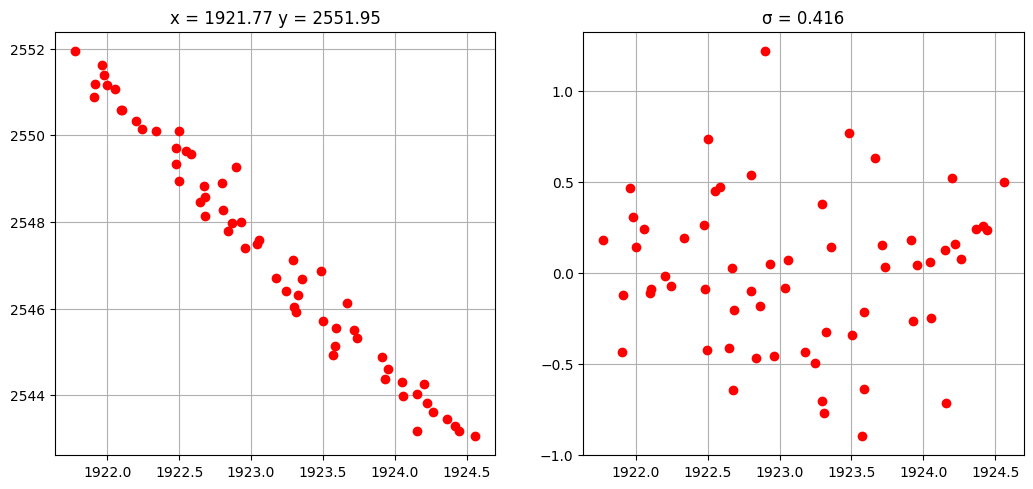

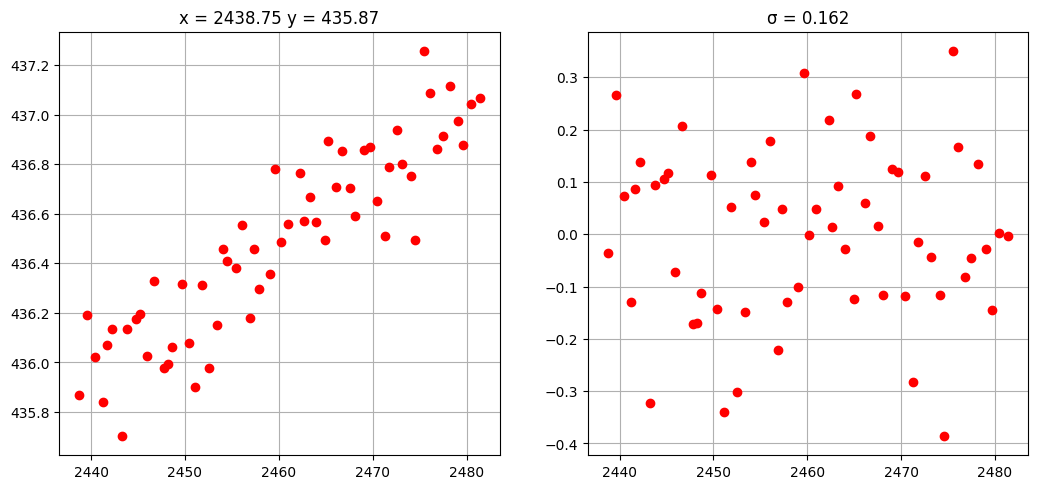

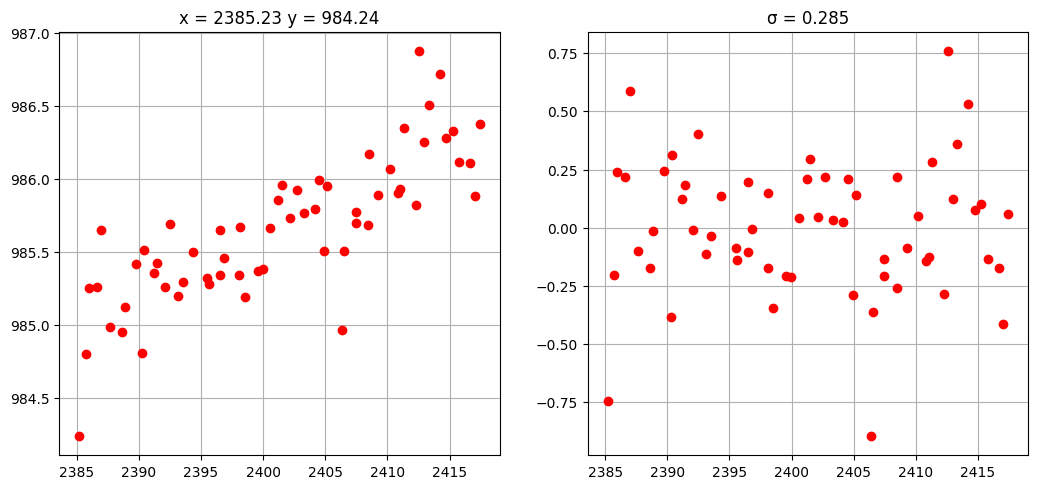

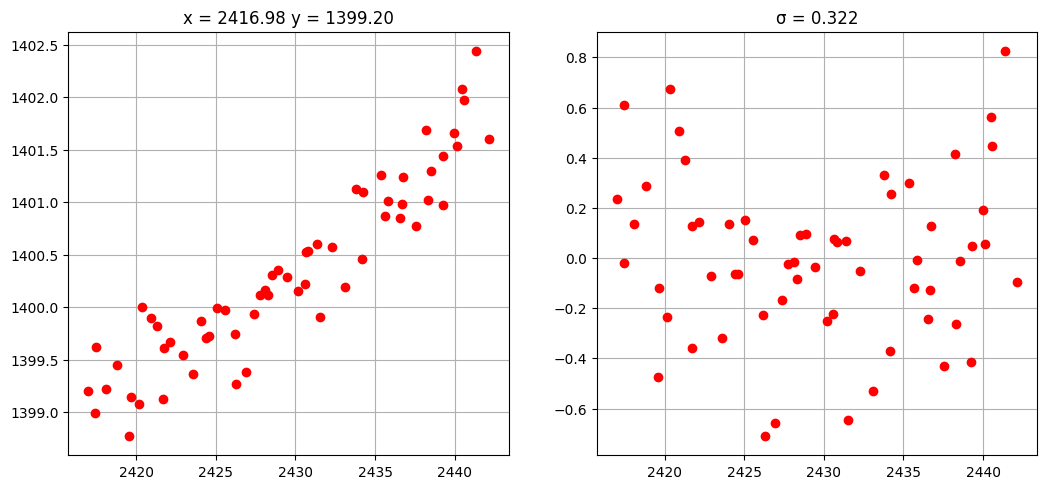

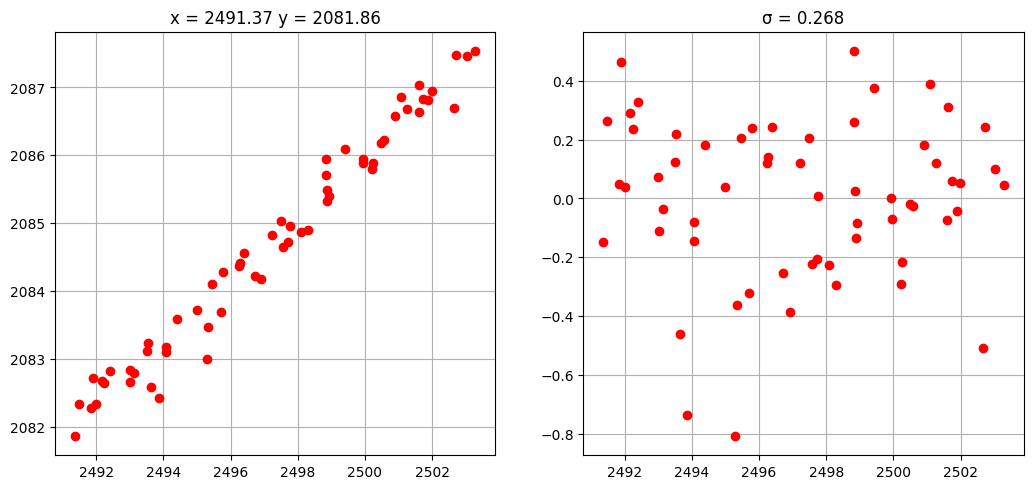

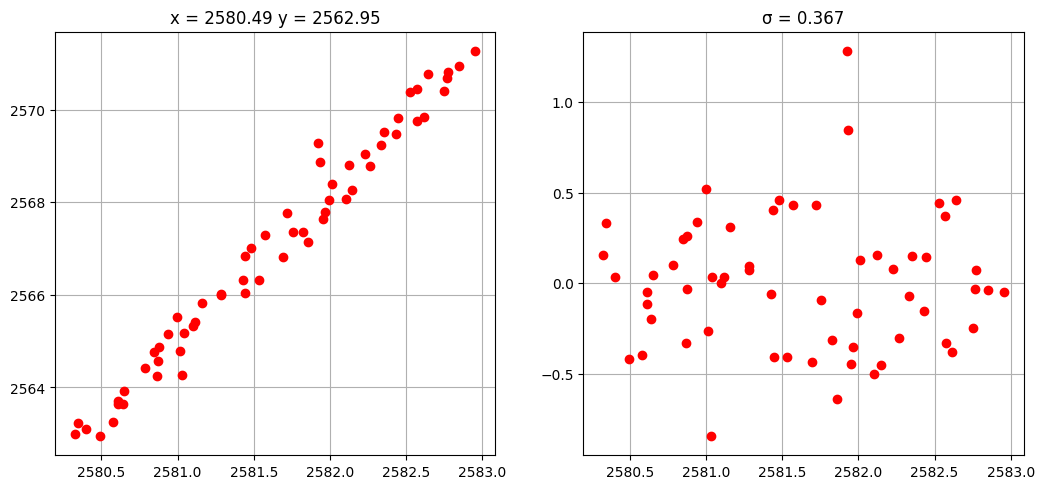

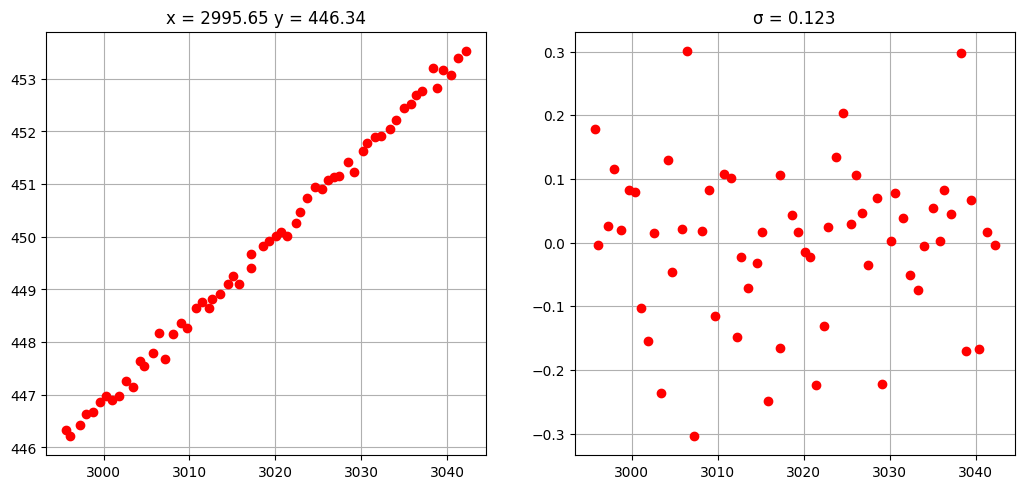

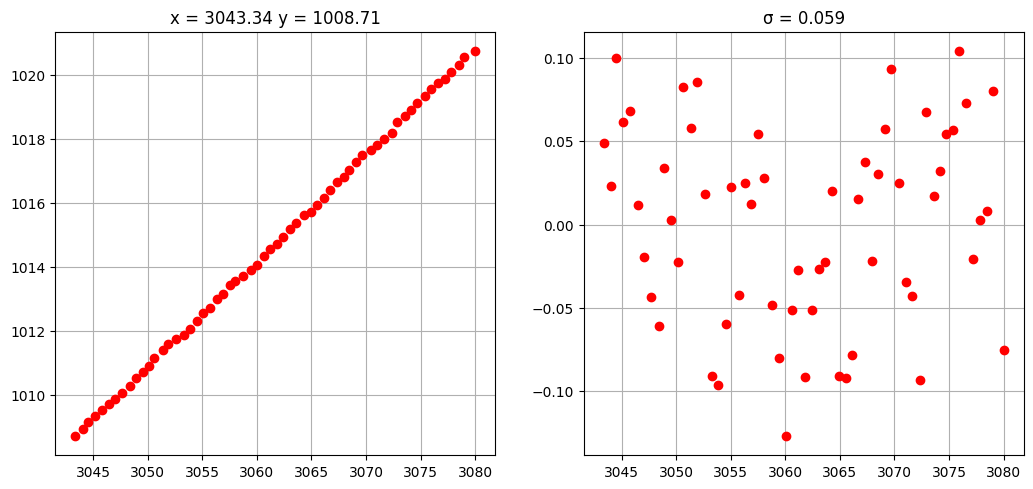

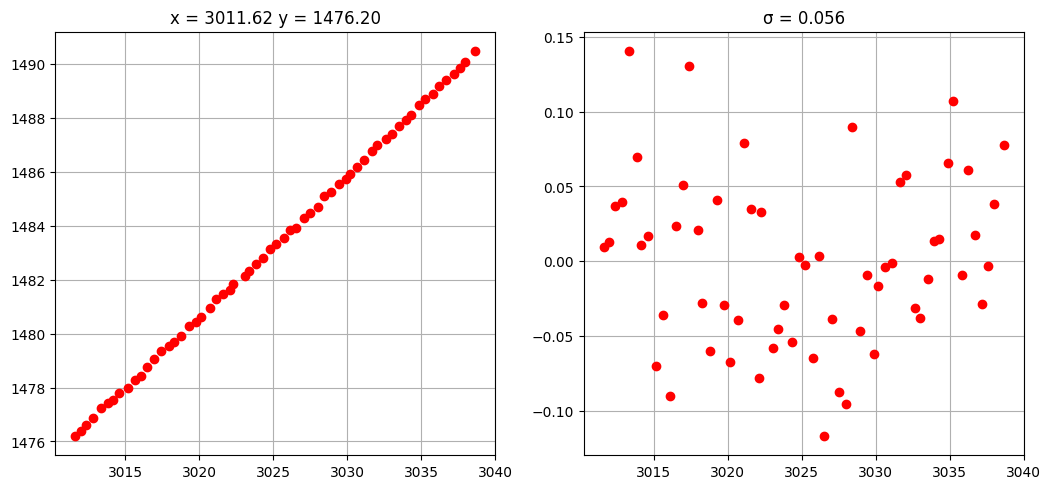

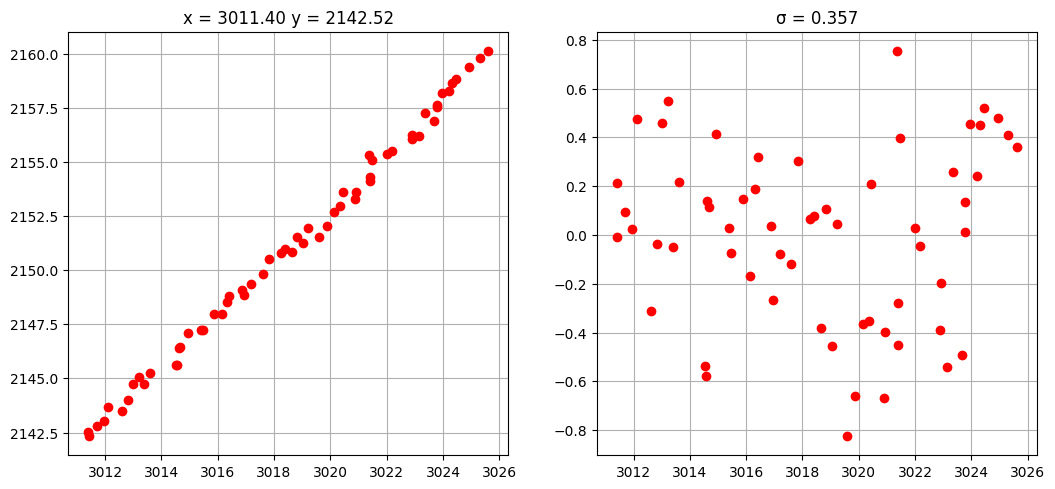

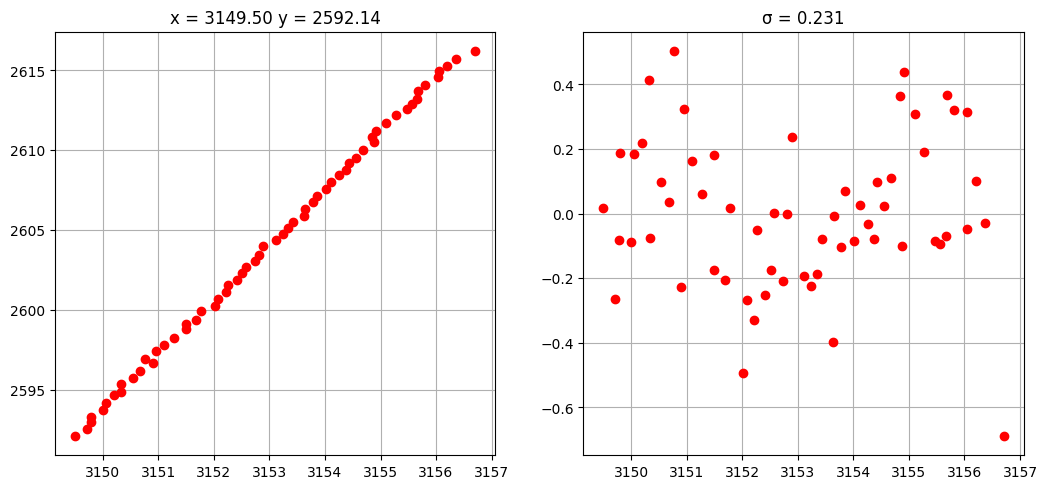

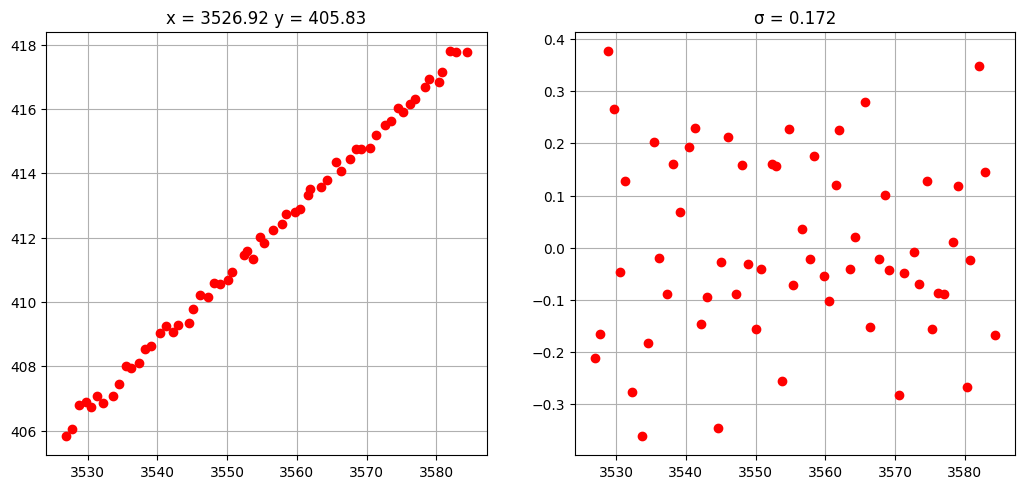

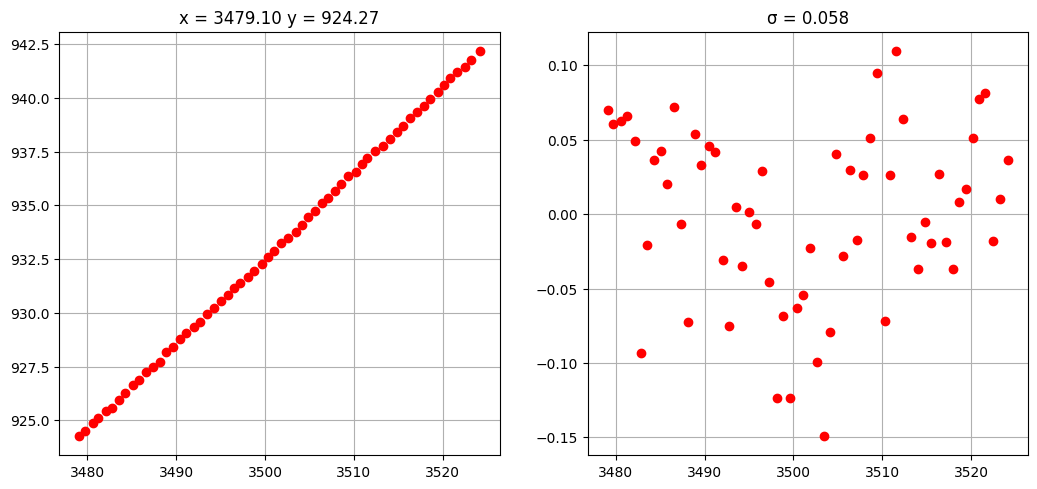

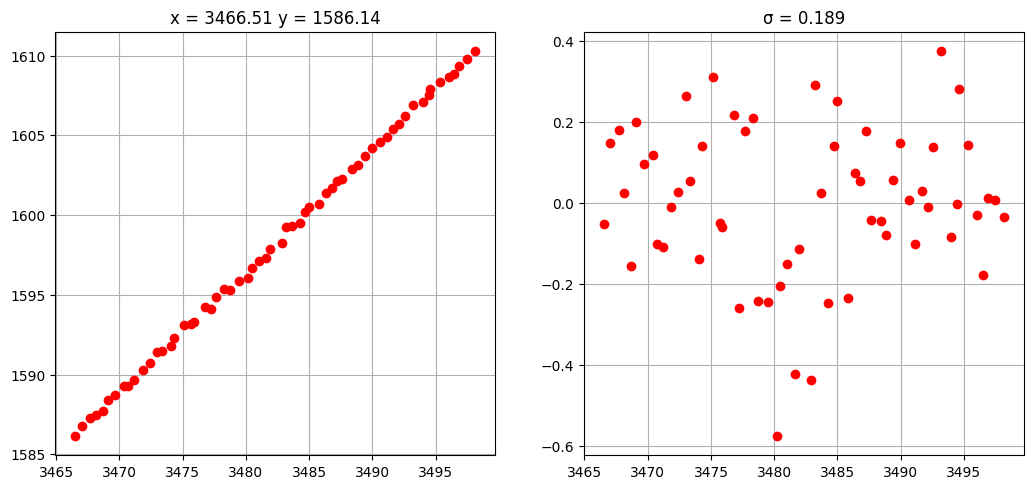

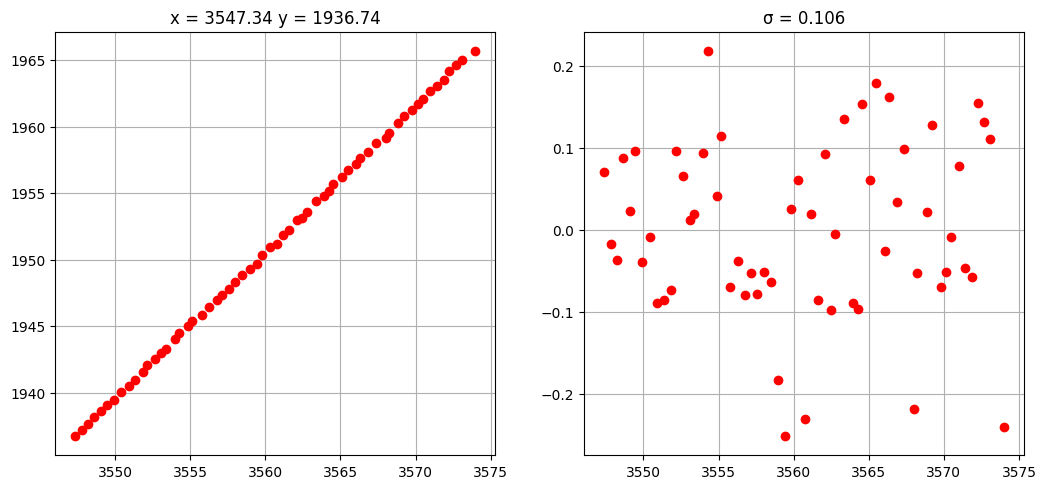

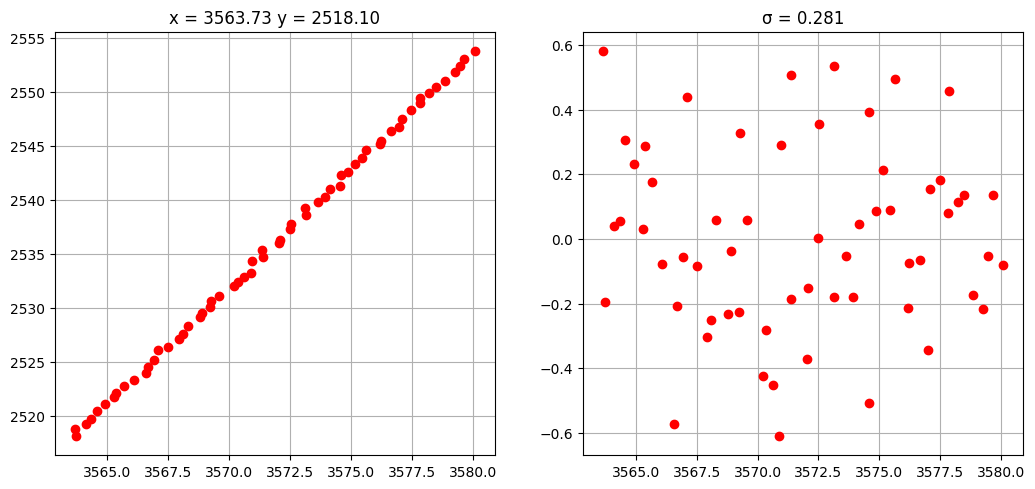

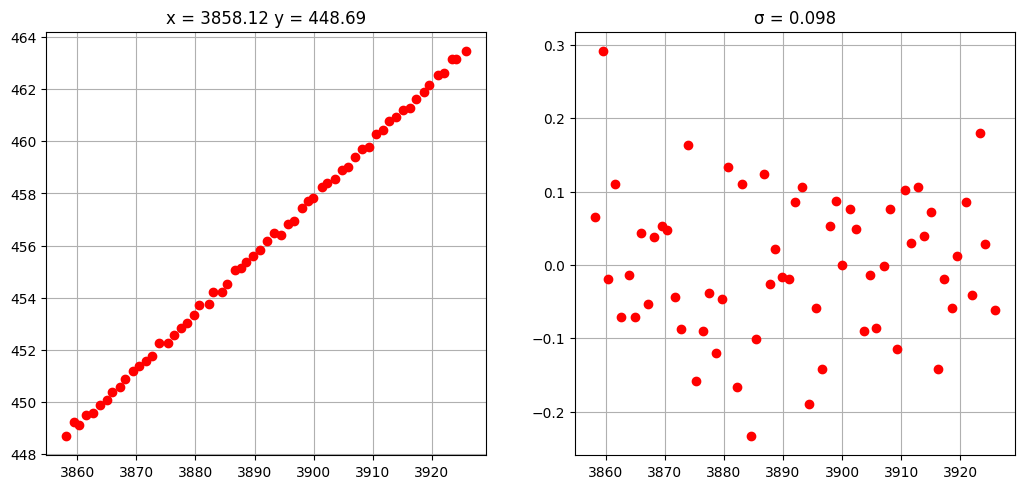

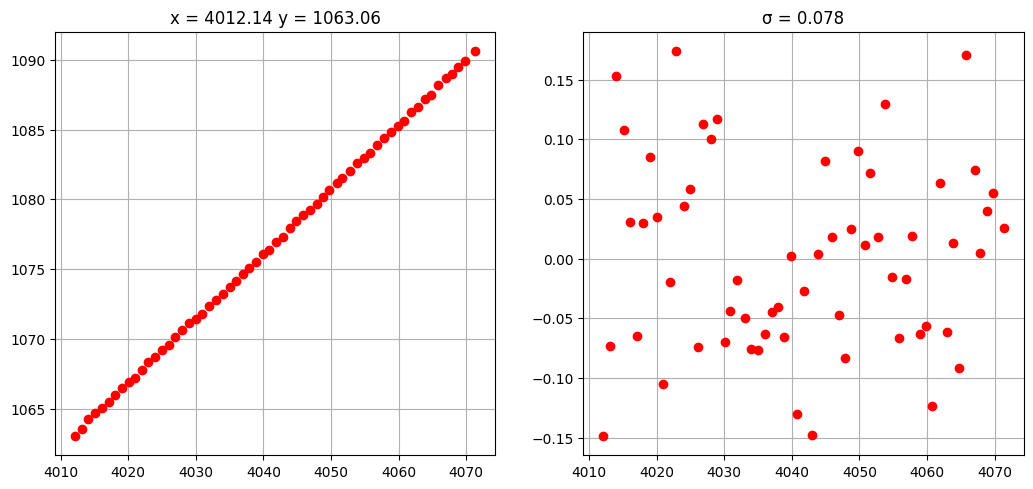

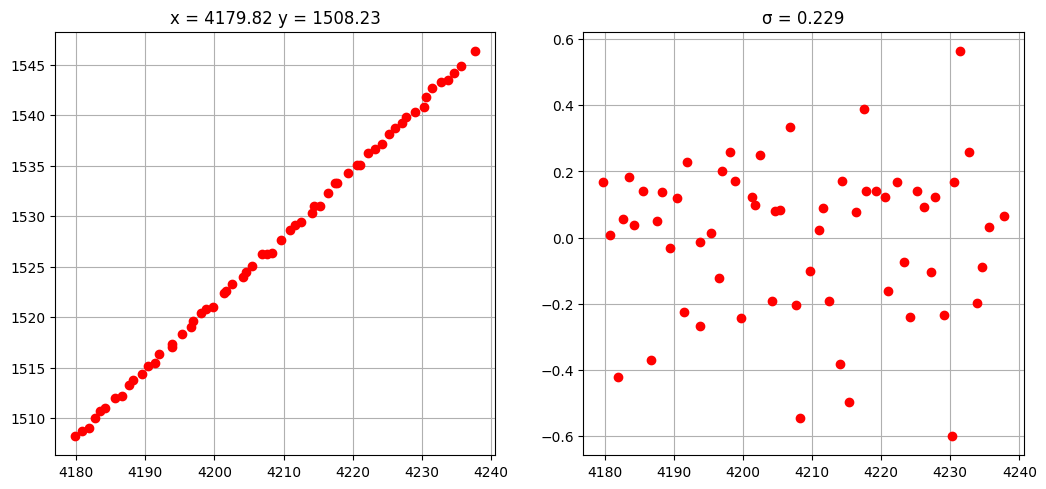

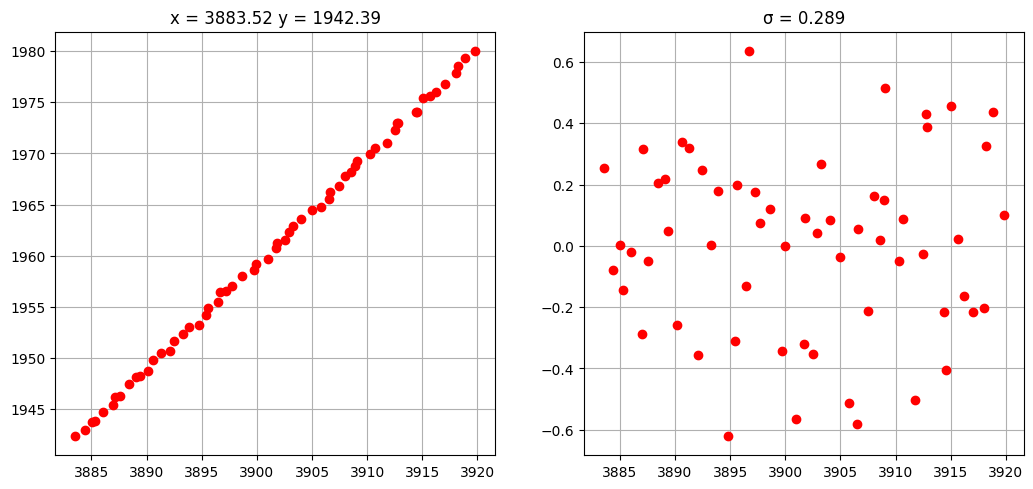

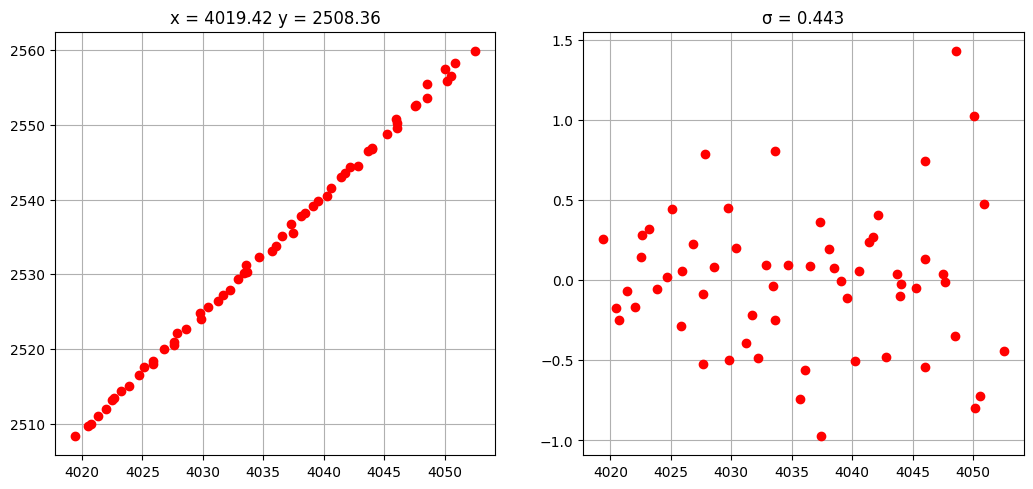

In [9]:
# step over evenly spaced positions in image, and pick nearest star for ploting.
step = 500
for x in range(step, nx, step):
    for y in range(step, ny, step):
        plot_residuals(x, y, table_list, nearest=True, large_resid=0.0) # only plot large residuals

In [10]:
# plot_residuals(158.65, 343.44, table_list, nearest=True)

## Reject stars

In [11]:
table_list_clean = reject_stars(table_list, residual_threshold=0.5)

11 0.7154228935396443
21 1.8031746952482244
97 0.7848039410490673
129 1.632769685046398
133 0.9472525682993939
271 0.5957786058764905
286 0.6065293026645061
311 0.5110666100476953
359 0.5192962255663377
365 0.5133158234610372
371 0.7615069338718424
372 0.5538461414069561
382 0.6350933369353178
383 0.5731119274448916
385 1.4746903888238614
388 0.6933042761403466
389 0.573283925307444
390 1.1262927158268243
391 0.6540463475781091
394 0.5385303433504861
395 1.0413356240747174
396 1.7835602756367772
397 1.1761488175950832
398 2.1108629831238934
400 3.615265246089016
401 0.9197139989489773
402 1.7755629824578498
405 1.576452435466346
406 0.7422960220960695
407 2.62474600022921
409 1.3487239222501406
410 0.6674682420891395
411 1.7715768752595964
412 1.5629342035302514
413 1.6922096703991645
415 0.8729538470298477


In [12]:
table_list_clean[-1]

xcentroid,ycentroid,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
float64,float64,float64,float64,float64,float64,int64,int64
1630.9768299044215,43.09972094250331,-49.7076884068108,8.12537908751844,-1.2035088021650608,0.002971307509078258,2,0
1700.9816654717,44.63528335076187,-49.537134942386956,8.247131020218497,-1.4906653434813961,1.0789380595600875,3,1
1806.531440109423,56.52669227781844,-48.44591606444942,6.799166063982625,-0.7281359836786123,0.1274959914829168,5,2
2764.439447752646,69.6063328593799,-51.52860157467785,-1.9931057095969464,-0.7709841892369695,0.10874278704523022,6,3
1580.0126797901557,84.33510317917664,-48.82289269067496,8.444669423405259,-0.7339237093274278,0.03340568421600665,7,4
1628.662902006418,125.17362804589145,-48.59914933597565,8.601722302117935,-1.36084229114158,0.37173430701092514,8,5
2003.4837086881605,137.3772052444409,-46.30557407750916,4.800114330721158,-0.7412578468643005,0.1409325508560073,10,6
1993.814469561847,139.7775702639233,-46.90840235851465,5.042394118367696,-1.101522721090305,0.3635728338187221,11,7
2204.7333378667036,151.35739685182375,-46.60151791740191,2.7671725510498106,-0.8367789757644459,0.05387193950136293,12,8


## Write cleaned tables

In [13]:
for i, tname_in in enumerate(file_list):
    tname_out = tname_in.replace('.offsets_table.fits','.offsets_table_clean.fits')
    
    table_list_clean[i].write(tname_out, overwrite=True)
    print(tname_out)

/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03770.offsets_table_clean.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03771.offsets_table_clean.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03772.offsets_table_clean.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03773.offsets_table_clean.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03774.offsets_table_clean.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03775.offsets_table_clean.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03776.offsets_table_clean.fits
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03777.offsets_table_clean.fits
/Volumes/Portabl

## Conclusions

Most of the residuals from a linear fit are of the order of a few tenths of a pixel. Depending on the position of the star on the sky, a linear fit may or may not be a good approximation, so that may account for a slight increase in the rms of the residuals. 

Overall the method seems to be satisfactory. 

In [14]:
Table.read('/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03829.offsets_table_clean.fits')

xcentroid,ycentroid,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
float64,float64,float64,float64,float64,float64,int64,int64
1630.9768299044215,43.09972094250331,-49.7076884068108,8.12537908751844,-1.2035088021650608,0.002971307509078258,2,0
1700.9816654717,44.63528335076187,-49.537134942386956,8.247131020218497,-1.4906653434813961,1.0789380595600875,3,1
1806.531440109423,56.52669227781844,-48.44591606444942,6.799166063982625,-0.7281359836786123,0.1274959914829168,5,2
2764.439447752646,69.6063328593799,-51.52860157467785,-1.9931057095969464,-0.7709841892369695,0.10874278704523022,6,3
1580.0126797901557,84.33510317917664,-48.82289269067496,8.444669423405259,-0.7339237093274278,0.03340568421600665,7,4
1628.662902006418,125.17362804589145,-48.59914933597565,8.601722302117935,-1.36084229114158,0.37173430701092514,8,5
2003.4837086881605,137.3772052444409,-46.30557407750916,4.800114330721158,-0.7412578468643005,0.1409325508560073,10,6
1993.814469561847,139.7775702639233,-46.90840235851465,5.042394118367696,-1.101522721090305,0.3635728338187221,11,7
2204.7333378667036,151.35739685182375,-46.60151791740191,2.7671725510498106,-0.8367789757644459,0.05387193950136293,12,8
